<h1>Density of K40 and Na23 in harmonic and box trap</h1> 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.units import Quantity
from typing import Union
from collections.abc import Sequence

from LightMat import BoseGas, FermiGas, ParticleProps

<h3>Harmonic and box potential definition</h3>

In [2]:
np.random.seed(42)

def harmonic_trap(
        x: Union[float, np.ndarray, Quantity],
        y: Union[float, np.ndarray, Quantity],
        z: Union[float, np.ndarray, Quantity],
        trap_depth: Union[float, Quantity] = 200,
        waist: Union[float, Quantity] = 50,
        inhomogenity: float = 0,
    ) -> Union[float, np.ndarray]:
    """Return a harmonic trap potential in [k_B x nK] for given position(s) in [μm].
    
        Args:
            x, y, z: position in [μm]
            trap_depth: trap depth in [k_B x nK]. Defaults to 200nK.
            waist: region in which we can model the trap as harmonic is [-waist, waist] in [μm]. Defaults to 50μm.
            inhomogenity: This number times `trap_depth` gives the noise magnitude. Defaults to 0.

        Returns:
            V(x, y, z): harmonic trap potential in [k_B x nK], array of same shape as x, y, z
    """
    if isinstance(x, Quantity) and x.unit.is_equivalent(u.um):
        x = x.to(u.um).value
    if isinstance(y, Quantity) and y.unit.is_equivalent(u.um):
        y = y.to(u.um).value
    if isinstance(z, Quantity) and z.unit.is_equivalent(u.um):
        z = z.to(u.um).value
    if isinstance(trap_depth, Quantity) and trap_depth.unit.is_equivalent(u.nK):
        trap_depth = trap_depth.to(u.nK).value
    if isinstance(waist, Quantity) and waist.unit.is_equivalent(u.um):
        waist = waist.to(u.um).value
    # Create Gaussian profile
    r_squared = x**2 + y**2 + z**2
    gaussian_profile = np.exp(-2 * r_squared / waist**2)

    # Apply the potential: -trap_depth at the center, 0 at the edges
    perfect_harmonic_trap = -trap_depth * gaussian_profile

    # Add noise
    np.random.seed(42)
    noise = np.random.rand(*perfect_harmonic_trap.shape, ) * inhomogenity * trap_depth
    return perfect_harmonic_trap + noise


def box_trap(
        x: Union[float, np.ndarray, Quantity],
        y: Union[float, np.ndarray, Quantity],
        z: Union[float, np.ndarray, Quantity],
        trap_depth: Union[float, Quantity] = 200.,
        box_width: Union[float, Sequence[float], Quantity] = (100., 100., 100.),
        inhomogenity: float = 0,
) -> Union[float, np.ndarray]:
    """Return a perfect box potential of depth `trap_depth` in [k_B x nK] for given position(s) in [μm].
       The size of the box in each direction around 0 is given by `box_width` in [μm].
    
        Args:
            x, y, z: position in [μm]
            trap_depth: box depth in [k_B x nK]. Defaults to 200nK.
            box_width: region [-box_width/2 μm, box_width/2 μm] is -`trap_depth`nK, else potential is 0nK.
                       Defaults to (100, 100, 100)μm.
            inhomogenity: This number times `trap_depth` gives the noise magnitude. Defaults to 0.

        Returns:
            V(x, y, z): box potential in [k_B x nK], array of same shape as x, y, z
    """
    if isinstance(x, Quantity) and x.unit.is_equivalent(u.um):
        x = x.to(u.um).value
    if isinstance(y, Quantity) and y.unit.is_equivalent(u.um):
        y = y.to(u.um).value
    if isinstance(z, Quantity) and z.unit.is_equivalent(u.um):
        z = z.to(u.um).value
    if isinstance(trap_depth, Quantity) and trap_depth.unit.is_equivalent(u.nK):
        trap_depth = trap_depth.to(u.nK).value
    if isinstance(box_width, Quantity) and box_width.unit.is_equivalent(u.um):
        box_width = box_width.to(u.um).value
    if isinstance(box_width, (int, float)):
        box_width = (box_width, box_width, box_width)
    # Check if the positions are within the box
    in_box = (np.abs(x) <= box_width[0] / 2) & \
             (np.abs(y) <= box_width[1] / 2) & \
             (np.abs(z) <= box_width[2] / 2)

    # Apply the potential: -trap_depth inside the box, 0 outside
    perfect_box = np.where(in_box, -trap_depth, 0.)

    # Add noise
    np.random.seed(42)
    noise = np.random.rand(*perfect_box.shape) * inhomogenity * trap_depth
    return perfect_box + noise


def ring_and_paint_beam_trap(
        X: Union[float, np.ndarray],
        Y: Union[float, np.ndarray],
        Z: Union[float, np.ndarray],
        ring_radius: Union[float, Quantity] = 60.0,
        paint_width: Union[float, Quantity] = 68.0,
        blue_trap_height: Union[float, Quantity] = 300.0, 
        red_trap_depth: Union[float, Quantity] = 100.0, 
        waist_ring: Union[float, Quantity] = 6.0,
        waist_paint: Union[float, Quantity] = 14.0,
        inhom_ring: Union[float, Quantity] = 0,
        inhom_paint: Union[float, Quantity] = 0,   
) -> Union[float, np.ndarray]:
    """Return a realistic box potential for given position(s) in [μm]. It consists of a blue ring 
       trap with depth `blue_trap_height` and a red paint trap of depth `red_trap_depth`. The size
       of the ring is given by `ring_radius` in [μm] and the width of the paint is `flat_z` in [μm].
       Both the ring and paint have Gaussian edges with waists `waist_xy` and `waist_z` respectively.

    
        Args:
            x, y, z: position in [μm]
            ring_radius: radius of the ring in [μm]. Defaults to 60μm.
            paint_width: width of the paint in [μm]. Defaults to 68μm.
            blue_trap_height: blue trap height of the ring in [k_B x nK]. Defaults to 300nK.
            red_trap_depth: red trap depth of the paint in [k_B x nK]. Defaults to 100nK.
            waist_ring: waist of the ring in [μm]. Defaults to 6μm.
            waist_paint: waist of the paint in [μm]. Defaults to 14μm.
            inhom_ring: This number times `blue_trap_height` gives the noise magnitude for the ring. Defaults to 0.
            inhom_paint: This number times `red_trap_depth` gives the noise magnitude for the paint. Defaults to 0.

        Returns:
            V(x, y, z): box potential in [k_B x nK], array of same shape as x, y, z
    """
    # Ensure X, Y, Z are numpy arrays
    if isinstance(X, Quantity) and X.unit.is_equivalent(u.um):
        X = X.to(u.um).value
    if isinstance(Y, Quantity) and Y.unit.is_equivalent(u.um):
        Y = Y.to(u.um).value
    if isinstance(Z, Quantity) and Z.unit.is_equivalent(u.um):
        Z = Z.to(u.um).value
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    Z = np.atleast_1d(Z)

    # Convert units to values
    if isinstance(ring_radius, Quantity) and ring_radius.unit.is_equivalent(u.um):
        ring_radius = ring_radius.to(u.um).value
    if isinstance(paint_width, Quantity) and paint_width.unit.is_equivalent(u.um):
        paint_width = paint_width.to(u.um).value
    if isinstance(blue_trap_height, Quantity) and blue_trap_height.unit.is_equivalent(u.nK):
        blue_trap_height = blue_trap_height.to(u.nK).value
    if isinstance(red_trap_depth, Quantity) and red_trap_depth.unit.is_equivalent(u.nK):
        red_trap_depth = red_trap_depth.to(u.nK).value
    if isinstance(waist_ring, Quantity) and waist_ring.unit.is_equivalent(u.um):
        waist_ring = waist_ring.to(u.um).value
    if isinstance(waist_paint, Quantity) and waist_paint.unit.is_equivalent(u.um):
        waist_paint = waist_paint.to(u.um).value
    
    # Calculate radial distance from the center (0, 0) for each point
    R = np.sqrt(X**2 + Y**2)
    # Setting potential to max value outside the ring
    Vxy = np.full_like(R, blue_trap_height)
    # Within the ring, calculate the Gaussian profile
    inside_ring = R <= (ring_radius)
    Vxy[inside_ring] = blue_trap_height * np.exp(-2 * (R[inside_ring] - ring_radius)**2 / waist_ring**2)
    
    # Create box trap profile with Gaussian edges for Z direction
    gaussian_edges_z = np.exp(-2 * (np.abs(Z) - paint_width / 2)**2 / waist_paint**2)
    Vz = -red_trap_depth * gaussian_edges_z / gaussian_edges_z.max()
    Vz[np.abs(Z) <= paint_width / 2] = -red_trap_depth

    # Add noise
    noise_ring = np.random.uniform(-1, 1, Vxy.shape) * inhom_ring * Vxy
    Vxy = Vxy + noise_ring
    noise_paint = np.random.uniform(-1, 1, Vz.shape) * inhom_paint * Vz
    Vz = Vz + noise_paint

    # Combine the XY and Z potentials
    V_trap = Vxy + Vz

    return V_trap

<h1>Harmonic trap density calculation</h1>

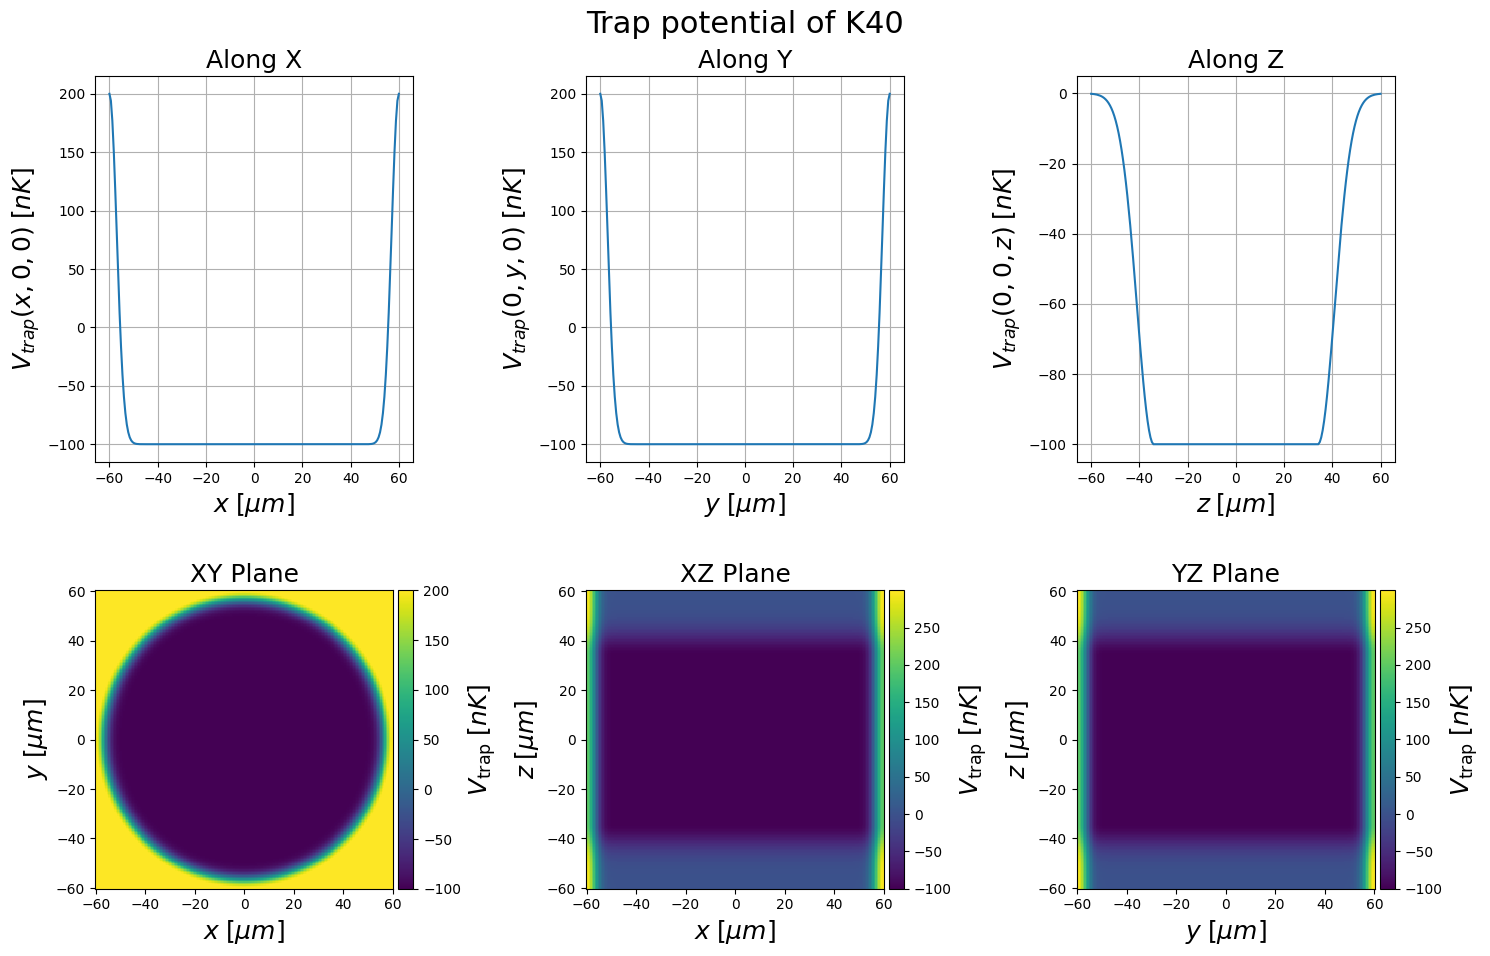

In [3]:
k40_harmonic = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=100000,
    T=0*u.nK,
    domain=(-60, 60)*u.um,
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap=harmonic_trap, 
    trap_depth=200*u.nK,
    waist=50*u.um,
    inhomogenity=0,
)

na23_harmonic = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=100000,
    T=0*u.nK,
    a_s=2.75*u.nm,
    domain=(-60, 60)*u.um,
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap=harmonic_trap,
    trap_depth=200*u.nK,
    waist=50*u.um,
    inhomogenity=0,
)

#k40_harmonic.plot_V_trap()
#na23_harmonic.plot_V_trap()

<h3>Calculate density...</h3>

In [4]:
fg_harmonic = FermiGas(k40_harmonic)
fg_harmonic.eval_density()

bg_harmonic = BoseGas(na23_harmonic)
bg_harmonic.eval_density()

# the array of the density can be found as fg.n_array or bg.n_array (also bg.n0_array and bg.n_ex_array)

Calculate n with TF approximation...


  5%|▌         | 51/1000 [00:01<00:28, 33.74it/s]


Convergence reached after 51 iterations.
Calculate n0 with TF approximation and n_ex with semiclassical HF approximation...


 52%|█████▏    | 52/100 [00:02<00:01, 24.75it/s]

Convergence reached after 52 iterations.


<h3>Plot density</h3>

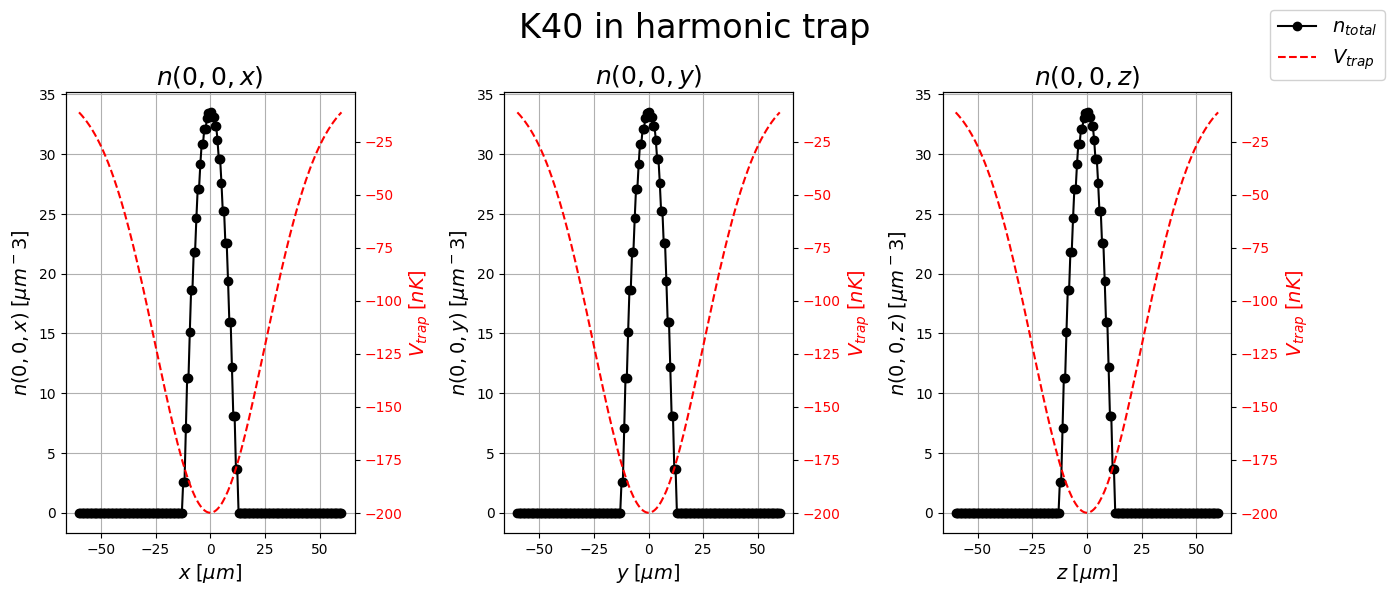

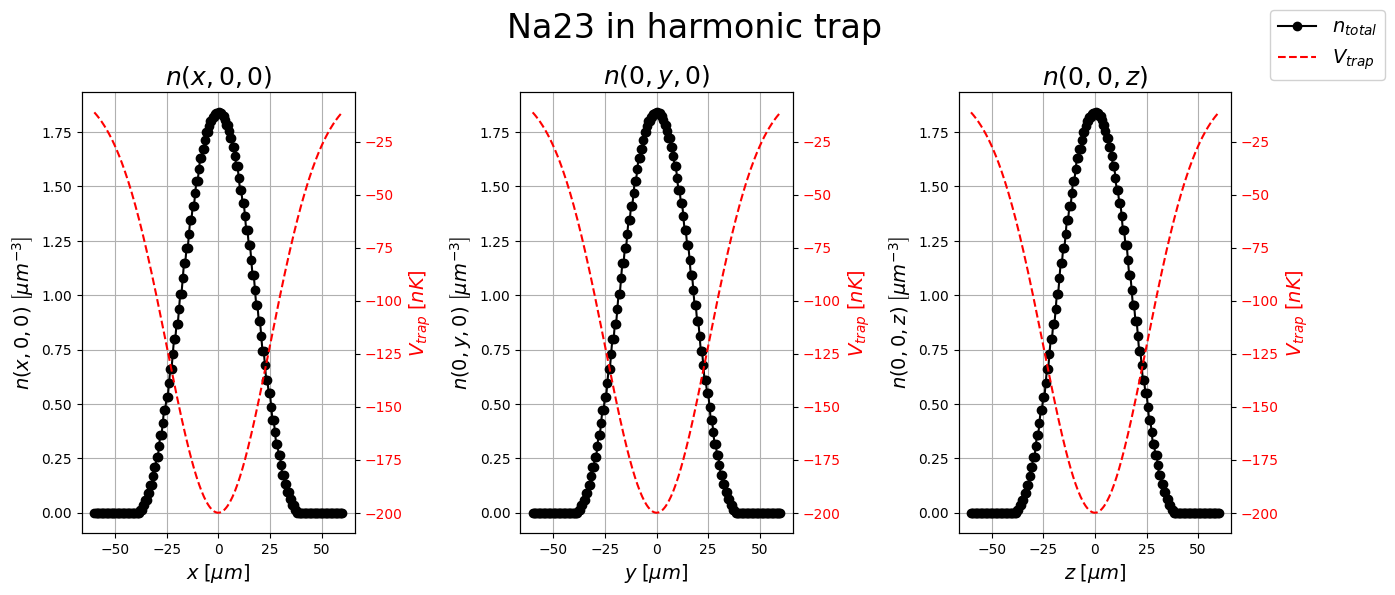

In [5]:
fig_bg = bg_harmonic.plot_density_1d(which='n', title="K40 in harmonic trap")
fig_fg = fg_harmonic.plot_density_1d(title="Na23 in harmonic trap")

<h3>Chemical potential</h3>

In [6]:
print('Chemical potential of K40 in harmonic trap: μ =', bg_harmonic.mu)
print('Chemical potential of Na23 in harmonic trap: μ =', fg_harmonic.mu)

Chemical potential of K40 in harmonic trap: μ = -175.5220033716944 nK
Chemical potential of Na23 in harmonic trap: μ = -61.45564238431497 nK


<h1>Box trap density calculation</h1>

In [12]:
k40_box = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=90000,
    T=0*u.nK,
    domain=(-60, 60)*u.um,
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap=box_trap, 
    trap_depth=200*u.nK,
    box_width=[100, 100, 100]*u.um,
    inhomogenity=0,
)

na23_box = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=114000,
    T=0*u.nK,
    a_s=2.75*u.nm,
    domain=(-60, 60)*u.um,
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap=box_trap,
    trap_depth=200*u.nK,
    box_width=[100, 100, 100]*u.um,
    inhomogenity=0,
)

#k40_box.plot_V_trap()
#na23_box.plot_V_trap()

<h3>Calculate density...</h3>

In [8]:
bg_box = BoseGas(na23_box)
bg_box.eval_density()

fg_box = FermiGas(k40_box)
fg_box.eval_density()

# the array of the density can be found as fg.n_array or bg.n_array (also bg.n0_array and bg.n_ex_array)

Calculate n0 with TF approximation and n_ex with semiclassical HF approximation...


 20%|██        | 20/100 [00:00<00:03, 23.32it/s]


Convergence reached after 20 iterations.
Calculate n with TF approximation...


  4%|▍         | 38/1000 [00:02<01:05, 14.75it/s]

Convergence reached after 38 iterations.


<h3>Plot density</h3>

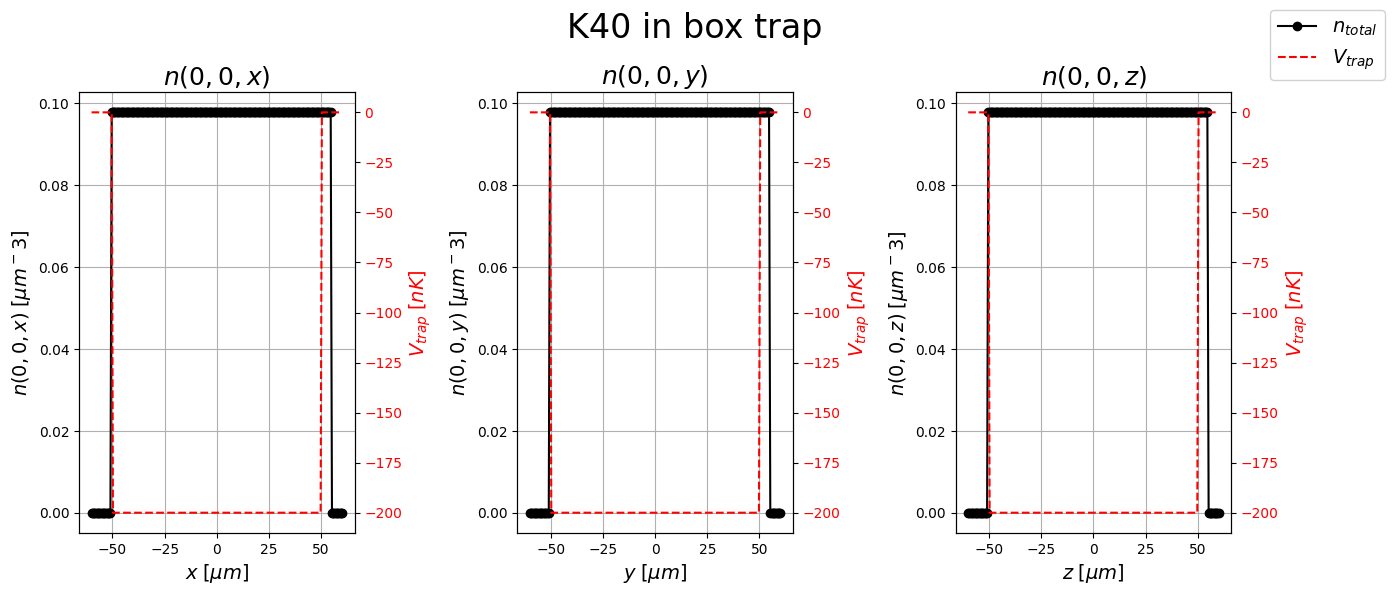

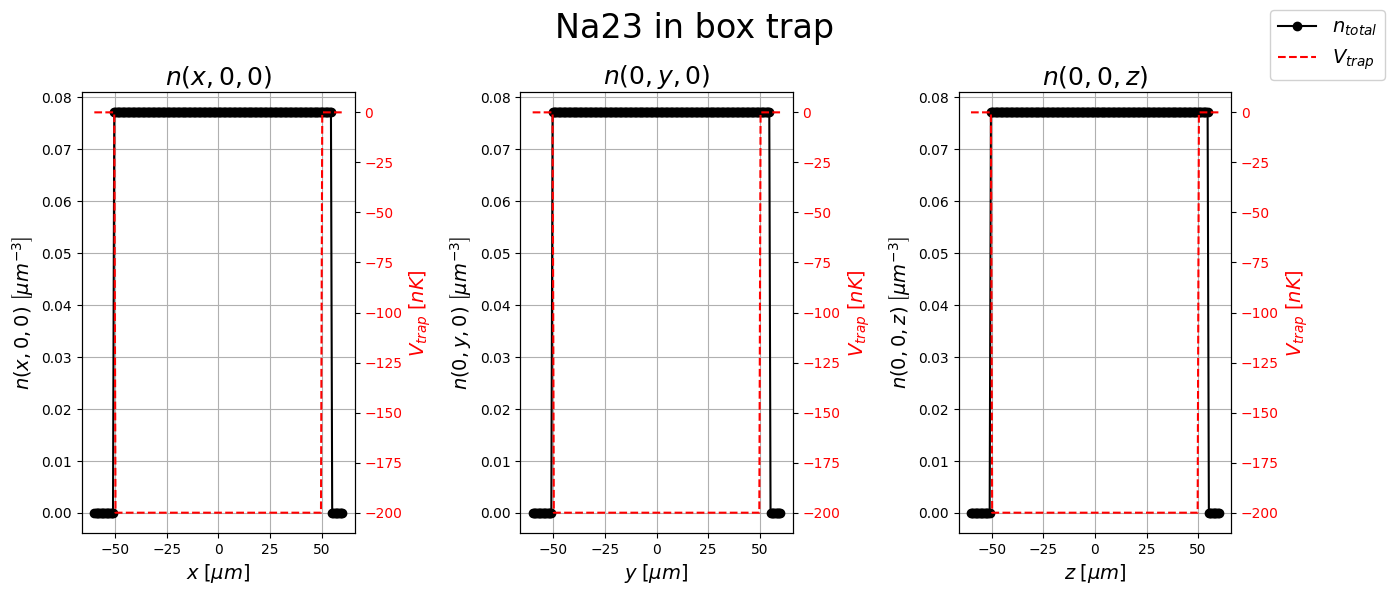

In [9]:
fig = bg_box.plot_density_1d(which='n', title="K40 in box trap")
fig = fg_box.plot_density_1d(title="Na23 in box trap")

<h3>Chemical potential</h3>

In [10]:
print('Chemical potential of K40 in box trap: μ =', bg_box.mu)
print('Chemical potential of Na23 in box trap: μ =', fg_box.mu)

Chemical potential of K40 in box trap: μ = -199.92876713285463 nK
Chemical potential of Na23 in box trap: μ = -183.29354035383096 nK
